# Applying Classification Modeling

The goal of this week's assessment is to find the model which best predicts whether or not a person will default on their credit card payment. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 


#### Data Set Information:

- This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

- NT is the abbreviation for New Taiwan. 


#### Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 = the repayment status in September, 2005; 
    - X7 = the repayment status in August, 2005; . . .;
    - etc...
    - X11 = the repayment status in April, 2005. 
    - The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). 
    - X12 = amount of bill statement in September, 2005;
    - etc...
    - X13 = amount of bill statement in August, 2005; . . .; 
    - X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). 
    - X18 = amount paid in September, 2005; 
    - X19 = amount paid in August, 2005; . . .;
    - etc...
    - X23 = amount paid in April, 2005. 




You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) to predict credit card defaults and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

- You will be working in pairs for this assessment

### Please have ONE notebook and be prepared to explain how you worked with your partner.

1. Clean up your data set so that you can perform an EDA. 
    - This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Engineer new features. 
    - Create polynomial and/or interaction features. 
    - Additionaly, you must also create **at least 2 new features** that are not interactions or polynomial transformations. 
        - *For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.*
4. Perform some feature selection. 
    
5. You must fit **three** models to your data and tune **at least 1 hyperparameter** per model. 
6. Using the F-1 Score, evaluate how well your models perform and identify your best model.
7. Using information from your EDA process and your model(s) output provide insight as to which borrowers are more likely to deafult


In [63]:
# import libraries

import pandas as pd
# more libraries here...
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
pd.set_option('display.max_columns', 300)

## 1. Data Cleaning

In [13]:
df = pd.read_csv('classification_lab_data.csv')

In [14]:
#First, easy steps, turning sex into a proper dummy, with just 0s and 1s
#Similarly, should turn education into set of dummies
df['SEX'] = df['SEX'] -1
educ_dummies = pd.get_dummies(df['EDUCATION'], prefix='edu')
df = pd.concat([df,educ_dummies],axis=1)
df.drop(['EDUCATION'],axis=1, inplace=True)

In [16]:
#Now, what to do with 'MARRIAGE'. I don't understand what the multiple categories are, let's investigate
df['MARRIAGE'].value_counts()
#We can see that almost everyone falls into the basic categories of married or single
#very few people in the 'other' category. My instinct is to turn this into a 
#dummy, just keep a flag for married and make everyon else 0

2    12735
1    10958
3      263
0       43
Name: MARRIAGE, dtype: int64

In [17]:
df['MARRIAGE'] = [1 if x==1 else 0 for x in df['MARRIAGE']]

In [64]:
df.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,edu_0,edu_1,edu_2,edu_3,edu_4,edu_5,edu_6
0,50000,0,0,49,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1,0,0,1,0,0,0,0
1,30000,0,1,39,0,0,0,0,0,0,20893,22206,19273,16469,14670,11214,2007,2000,2000,417,1500,1500,0,0,0,1,0,0,0,0
2,260000,0,0,27,0,0,0,0,0,0,158711,129796,101721,76699,56738,39134,30000,4132,3410,2600,1800,1200,0,0,1,0,0,0,0,0
3,200000,1,1,33,0,0,0,0,0,0,23762,25944,26988,25237,22131,13774,4000,2000,600,3000,4000,100,0,0,0,1,0,0,0,0
4,50000,0,0,27,0,0,0,0,0,0,14614,15622,16342,17653,17697,18068,1558,1278,1589,633,656,783,0,0,1,0,0,0,0,0


In [31]:
df[df['edu_2']==1]['PAY_6'].describe()

count    11188.000000
mean        -0.164015
std          1.138564
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_6, dtype: float64

In [34]:
df[df['default payment next month']==1]['PAY_6'].describe()

count    5308.000000
mean        0.116993
std         1.480630
min        -2.000000
25%        -1.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: PAY_6, dtype: float64

In [35]:
df[df['default payment next month']==0]['PAY_6'].describe()

count    18691.000000
mean        -0.400246
std          1.008757
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: PAY_6, dtype: float64

In [40]:
df['AGE'].describe()

count    23999.000000
mean        35.523230
std          9.253986
min         21.000000
25%         28.000000
50%         34.000000
75%         42.000000
max         79.000000
Name: AGE, dtype: float64

In [61]:
df[(df['AGE']>30)&(df['AGE']<40)]['default payment next month'].mean()

0.20186533793279673

## 2. EDA

In [5]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [116]:
df['PAY_6'].value_counts()

 0    13096
-1     4560
-2     3878
 2     2211
 3      146
 4       42
 7       39
 6       14
 5       11
 8        2
Name: PAY_6, dtype: int64

In [62]:
df['default payment next month'].describe()

count    23999.000000
mean         0.221176
std          0.415047
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default payment next month, dtype: float64

## 3. Feature Engineering

So, after some discussion, we came up with a series of features we wanted to explore on the notion that they seemed like they might intuitively have some power. In this section we'd like to make them and do a quick check to see if they do actually correlate to the default rate meaningfully. For context, the average default rate over the entire population is around 22%

Our initial thoughts included the following features:
1. Is your balance increasing or decreasing: if you have a balance but are paying it down month over month without incurring substantial new debt, that seems like a good sign even if you still have a substantial balance remaining
2. Are there spikes in the balance you carry? If you typically have a low balance, but a month or two out you suddenly incur a lot of debt, that seems like a sign of something extreme happening
3. Balance as a % of credit limit: obviously, the overall balance seems important, but having a credit limit that is proportionally higher than your balance seems like it would be a good sign, even if you're carrying debt
4. Age brackets: the effect of age on default rate is likely not linear, middle age peole may default less than young people, but default rates seem to go up once you hit retirement age
5. Age interacted with marriage status/payment status etc: can we identify high or low risk demographic pockets?

In [302]:
#Is your balance increasing or decreasing. It occurs to me that there are two easy ways. 1) strictly in/decreasing
#where each month is lower than the previous. and 2) generally in/decreasing where you simply compare
#the first and last periods. Let's explore both
def strict_dec(n):
    if (df.loc[n]['BILL_AMT1'] < df.loc[n]['BILL_AMT2'] < df.loc[n]['BILL_AMT3']< 
        df.loc[n]['BILL_AMT4']< df.loc[n]['BILL_AMT5']< df.loc[n]['BILL_AMT6']):
        return 1
    else:
        return 0

def strict_inc(n):
    if (df.loc[n]['BILL_AMT1'] >df.loc[n]['BILL_AMT2'] > df.loc[n]['BILL_AMT3']> 
        df.loc[n]['BILL_AMT4']> df.loc[n]['BILL_AMT5']> df.loc[n]['BILL_AMT6']):
        return 1
    else:
        return 0

df['strict_dec'] = [strict_dec(n) for n in range(0,len(df))]
df['strict_inc'] = [strict_inc(n) for n in range(0,len(df))]

In [303]:
print('strictly decreasing: ',df['strict_dec'].sum())
print('strict_dec default rate: ', round((df[df['strict_dec']==1]['default payment next month'].mean())*100,2))
print('strictly increasing: ',df['strict_inc'].sum())
print('strict_inc default rate: ', round(df[df['strict_inc']==1]['default payment next month'].mean()*100,2))

strictly decreasing:  1592
strict_dec default rate:  22.74
strictly increasing:  1335
strict_inc default rate:  16.25


Honestly, this is less dramatic than I would have expected. The strictly decreasing tag doesn't seem to be useful at all. Surprisingly, people with strictly increase bill amounts default at a lower rate? Curious....

array([[1.       , 0.0887891],
       [0.0887891, 1.       ]])

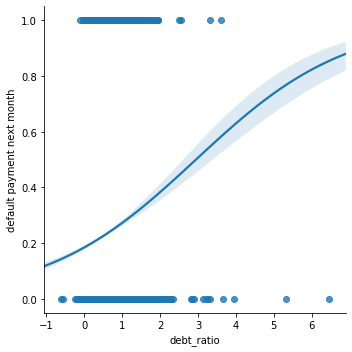

In [318]:
#Debt as % of limit:
df['debt_ratio'] = df['BILL_AMT1']/df['LIMIT_BAL']
sns.lmplot(x='debt_ratio',y='default payment next month', data=df, logistic=True)
np.corrcoef(df['debt_ratio'],df['default payment next month'])

Next going to look at spikes in balances. First way is just looking at whether you had a spike in the last couple of months, as defined by a fraction of your overall credit limit. It doesn't look to be super meaningful....

Next I'm going to try to do something similar with the overall increase in your balance, on its own, not as a fraction of credit limit.

In [307]:
def had_spike_perc(n):
    growth = df.loc[n]['BILL_AMT1'] - df.loc[n]['BILL_AMT3']
    if growth <0:
        return 0
    if growth/df.loc[n]['LIMIT_BAL'] > .75:
        return 1
    else:
        return 0

df['had_spike'] = [had_spike_perc(n) for n in range(0,len(df))]

In [308]:
df['had_spike'].sum()

352

In [309]:
df[df['had_spike']==1]['default payment next month'].mean()

0.2215909090909091

Overall increase in balance appears to be somewhat related, but not substantially.

array([[ 1.        , -0.02010505],
       [-0.02010505,  1.        ]])

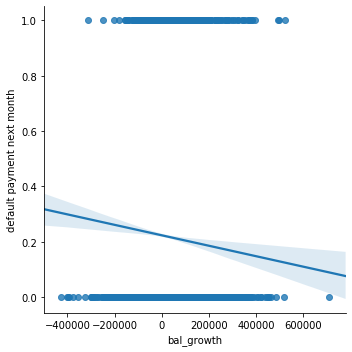

In [310]:
df['bal_growth'] = df['BILL_AMT1'] - df['BILL_AMT6']
sns.lmplot(x='bal_growth',y='default payment next month', data=df)
np.corrcoef(df['bal_growth'],df['default payment next month'])

In [311]:
#Growth in last month's balance, also appears to be useuless.
df['final_growth'] = df['BILL_AMT1'] - df['BILL_AMT2']
df['final_growth'].describe()

count     23999.000000
mean       2067.336597
std       22790.128154
min     -489972.000000
25%       -1529.000000
50%           0.000000
75%        2274.000000
max      470400.000000
Name: final_growth, dtype: float64

array([[ 1.        , -0.01627195],
       [-0.01627195,  1.        ]])

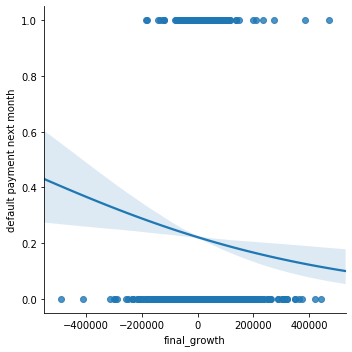

In [317]:
sns.lmplot(x='final_growth',y='default payment next month', data=df, logistic=True)
np.corrcoef(df['final_growth'],df['default payment next month'])

Howabout if you've been carrying a balance and then don't make a payment

In an effort to both simplify the feature set and possibly tease out the people who defaulted even if they had made timely payments immediately beforehand. First, we're going to make a summary feature which adds up positive values in previous pay periods (i.e. previous late payments). Then we're going to see if this has any bearing on people who made a timely payment in period 0, but still defaulted.

In [270]:
def sum_pay_cat(n):
    value = 0
    if df.loc[n]['PAY_0'] > 0:
        value += df.loc[n]['PAY_0']
    if df.loc[n]['PAY_2'] > 0:
        value += df.loc[n]['PAY_2']
    if df.loc[n]['PAY_3'] > 0:
        value += df.loc[n]['PAY_3']
    if df.loc[n]['PAY_4'] > 0:
        value += df.loc[n]['PAY_4']
    if df.loc[n]['PAY_5'] > 0:
        value += df.loc[n]['PAY_5']
    if df.loc[n]['PAY_6'] > 0:
        value += df.loc[n]['PAY_6']
    return value

df['pay_cat_sum'] = [sum_pay_cat(n) for n in range(0,len(df))]

array([[1.        , 0.37495232],
       [0.37495232, 1.        ]])

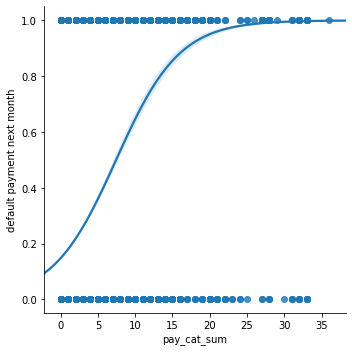

In [315]:
sns.lmplot(x='pay_cat_sum',y='default payment next month', data=df, logistic=True)
np.corrcoef(df['pay_cat_sum'],df['default payment next month'])

Notice that if you made a timely payment in period 0, you have a very low default rate - around 13/14%. If, however, you had any late payments in previous payment periods, your default rates go up substantially:
pay_cat_sum > 1 - 27% default rate
pay_cat_sum > 2 - 33% default rate
pay_cat_sum > 5 - 39% default rate

This suggests that we should have a flag for any previous defaults for people with payments immediately before hand, and also for including this interacted with good repayment

0.4990808823529412
5440
0.7004366812227074
1145


array([[1.        , 0.16972263],
       [0.16972263, 1.        ]])

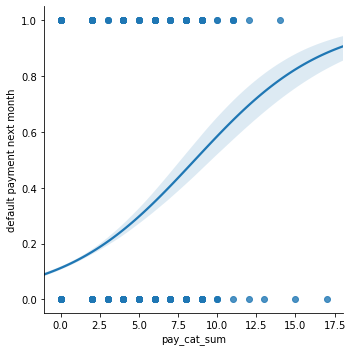

In [316]:
print(df[(df['PAY_0']>0)]['default payment next month'].mean())
print(len(df[df['PAY_0']>0]))
print(df[(df['PAY_0']>0)&(df['pay_cat_sum']>10)]['default payment next month'].mean())
print(len(df[(df['PAY_0']>0)&(df['pay_cat_sum']>10)]))
sns.lmplot(x='pay_cat_sum',y='default payment next month', data=df[df['PAY_0']==-0], logistic=True)
np.corrcoef(df[df['PAY_0']==-0]['pay_cat_sum'],df[df['PAY_0']==-0]['default payment next month'])

In [299]:
df['good_payment_standing'] = [1 if df.loc[n]['PAY_0']<1 else 0 for n in range(0,len(df))]
df['bad_payment history'] = [1 if df.loc[n]['pay_cat_sum']>0 else 0 for n in range(0,len(df))]
df['good_standing_bad_history'] = df['good_payment_standing']*df['bad_payment history']
df['past_pay_cat_sum'] = df['good_payment_standing'] * df['pay_cat_sum']

Now to add in some age brackets, as dummies. Our previous exploration made it seem like older people become more at risk for default after a certain age. Women default at lower rates than men in general, but there seem to be a few places where the trend reverses (particularly after 55, which appears to be the retirement age for women in Taiwan) Where are the best cut offs for ages in general? And where are there other trends like this? Let's look at the default rates for people of each age, split across genders/marital statuses.

I'm going to make a data frame with this info.

In [186]:
comp_dict = {}
for age in range(21,61):
    comp_dict[age] = {'single_woman':df[(df['AGE']==age)&(df['MARRIAGE']==0)&(df['SEX']==1)]['default payment next month'].mean(),
                     'single_man': df[(df['AGE']==age)&(df['MARRIAGE']==0)&(df['SEX']==0)]['default payment next month'].mean(),
                     'married_woman':df[(df['AGE']==age)&(df['MARRIAGE']==1)&(df['SEX']==1)]['default payment next month'].mean(),
                     'married_man': df[(df['AGE']==age)&(df['MARRIAGE']==1)&(df['SEX']==0)]['default payment next month'].mean(),
                      'married_avg': df[(df['AGE']==age)&(df['MARRIAGE']==1)]['default payment next month'].mean(),
                      'single_avg': df[(df['AGE']==age)&(df['MARRIAGE']==0)]['default payment next month'].mean(),
                      'men_avg': df[(df['AGE']==age)&(df['SEX']==0)]['default payment next month'].mean(),
                      'women_avg': df[(df['AGE']==age)&(df['SEX']==1)]['default payment next month'].mean(),
                     'age_ave': df[df['AGE']==age]['default payment next month'].mean()}
comp_df = pd.DataFrame(comp_dict).T
comp_df['married_man'] = comp_df['age_ave']-comp_df['married_man']
comp_df['married_woman'] = comp_df['age_ave']-comp_df['married_woman']
comp_df['single_man'] = comp_df['age_ave']-comp_df['single_man']
comp_df['single_woman'] = comp_df['age_ave']-comp_df['single_woman']
comp_df['married_avg'] = comp_df['age_ave'] - comp_df['married_avg']
comp_df['single_avg'] = comp_df['age_ave'] - comp_df['single_avg']
comp_df['men_avg'] = comp_df['age_ave'] - comp_df['men_avg']
comp_df['women_avg'] = comp_df['age_ave'] - comp_df['women_avg']

First, just looking at the average default rates by age.

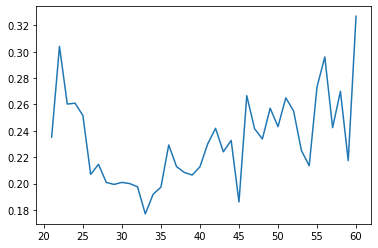

In [180]:
plt.plot(comp_df['age_ave'])

Visually, it looks to me like there are a few clear trends:
1. High default rates for people below 25
2. Generally low default rates for people between 25 and say 35
3. Over 35, default rates start to go up steadily, with a few blips - hard to tell if 45 is a fluke or if there's something about that age
4. Rates go up substantially once you hit retirement ages - 55 to 60

My intuition is to therefore break out the significantly different age brackets. Let 25-35 be the model default, and put in flags for under 25, 35-54 and 55 and up

Now let's look through some of the breakdowns. These are plotted as better/worse than age average default rate

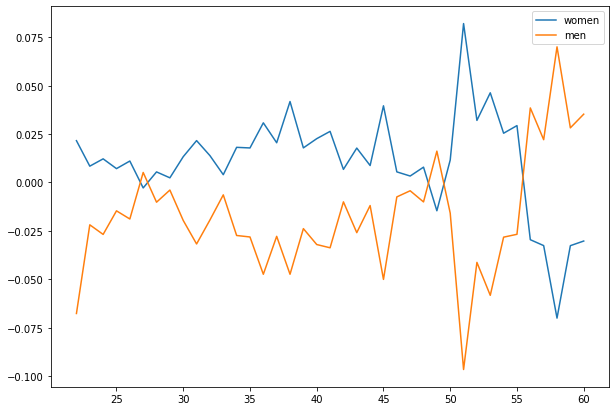

In [187]:
#Women are safer than men in general, frequently by a hefty margin, with the important exception of the
#years following 55, which is the retirement age for women in Taiwan
plt.figure(figsize=(10,7))
plt.plot(comp_df['women_avg'][1:], label='women')
plt.plot(comp_df['men_avg'][1:], label='men')
plt.legend()

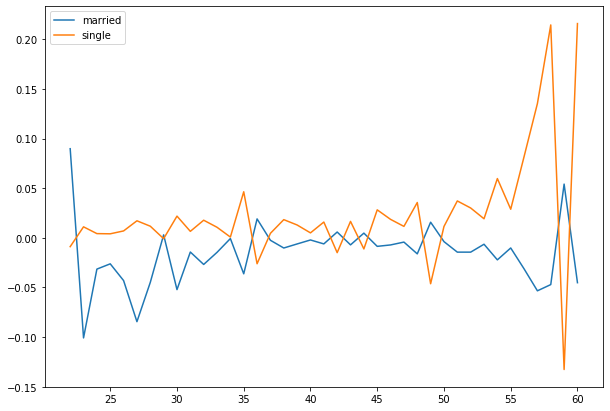

In [193]:
#Single people generally default less married people, particularly in the older cohorts
plt.figure(figsize=(10,7))
plt.plot(comp_df['married_avg'][1:], label='married')

plt.plot(comp_df['single_avg'][1:], label='single')
plt.legend()

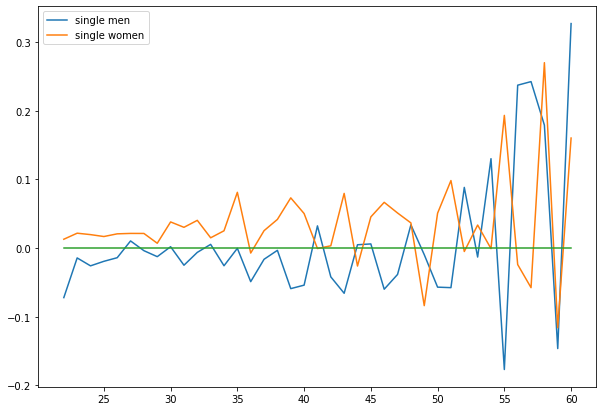

In [200]:
#But the difference between single and married is mostly due to the women, single men tend to be at average
#or a bit below average default rates
plt.figure(figsize=(10,7))
plt.plot(comp_df['single_man'][1:], label='single men')
plt.plot(comp_df['single_woman'][1:], label='single women')
plt.plot(comp_df.index[1:],np.zeros(39,))
plt.legend()

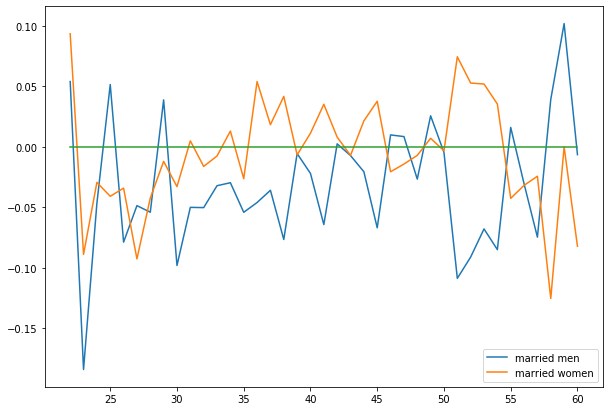

In [201]:
plt.figure(figsize=(10,7))
plt.plot(comp_df['married_man'][1:], label='married men')
plt.plot(comp_df['married_woman'][1:], label='married women')
plt.plot(comp_df.index[1:],np.zeros(39,))
plt.legend()

So let's make some age related dummies:
1. age 25 and under
2. 25 - 35
3. 35 - 54
4. 55 and up
5. an extra flag for women over 55
6. an extra flag for single people in their 50's

In [300]:
df['under_25'] = [1 if df.loc[n]['AGE'] < 26 else 0 for n in range(0,len(df))]
df['25_to_35'] = [1 if df.loc[n]['AGE'] > 25 and df.loc[n]['AGE'] < 36 else 0 for n in range(0,len(df))]
df['35_to_54'] = [1 if df.loc[n]['AGE'] > 35 and df.loc[n]['AGE'] < 55 else 0 for n in range(0,len(df))]
df['55_and_up'] = [1 if df.loc[n]['AGE'] > 54 else 0 for n in range(0,len(df))]
df['retired_women'] = df['55_and_up']*df['SEX']
df['single_50s'] = [1 if df.loc[n]['AGE'] > 50 and df.loc[n]['MARRIAGE']==0 else 0 for n in range(0,len(df))]

In [280]:
df['PAY_0'].value_counts()

 0    11835
-1     4544
 1     2942
-2     2180
 2     2120
 3      265
 4       62
 5       23
 8       15
 7        7
 6        6
Name: PAY_0, dtype: int64

In [290]:
print(df[(df['PAY_0']==0)]['default payment next month'].mean())
print(df[(df['PAY_0']==0)&(df['strict_inc']==1)&(df['edu_1']==1)]['default payment next month'].mean())
print(df[(df['PAY_0']==0)&(df['strict_inc']==1)&(df['edu_2']==1)]['default payment next month'].mean())
print(df[(df['PAY_0']==0)&(df['strict_inc']==1)&(df['edu_3']==1)]['default payment next month'].mean())

0.13020701309674693
0.07650273224043716
0.15409309791332262
0.17777777777777778


In [274]:
print(len(df[(df['PAY_0']==0)&(df['strict_dec']==1)&(df['edu_1']==1)]))
print(len(df[(df['PAY_0']==0)&(df['strict_dec']==1)&(df['edu_2']==1)]))

327
523


In [281]:
print(df[(df['PAY_0']==-1)]['default payment next month'].mean())
print(df[(df['PAY_0']==-1)&(df['had_spike']==1)&(df['edu_1']==1)]['default payment next month'].mean())
print(df[(df['PAY_0']==-1)&(df['had_spike']==1)&(df['edu_2']==1)]['default payment next month'].mean())
print(df[(df['PAY_0']==-1)&(df['had_spike']==1)&(df['edu_3']==1)]['default payment next month'].mean())
print(len(df[(df['PAY_0']==-1)&(df['had_spike']==1)&(df['edu_1']==1)]))
print(len(df[(df['PAY_0']==-1)&(df['had_spike']==1)&(df['edu_2']==1)]))
print(len(df[(df['PAY_0']==-1)&(df['had_spike']==1)&(df['edu_3']==1)]))

0.1701144366197183
0.2
0.21052631578947367
0.0
10
19
10


In [256]:
len(df[df['edu_0']==1])

11

In [ ]:
df[(df['PAY_6']==0)&(df['strict_dec']==1)&(df['edu_1']==1)]['default payment next month']

array([[1.        , 0.07679614],
       [0.07679614, 1.        ]])

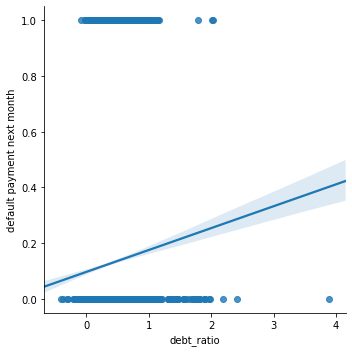

In [282]:
sns.lmplot(x='debt_ratio',y='default payment next month', 
           data=df[df['PAY_0']==0])
np.corrcoef(df[df['PAY_0']==0]['debt_ratio'],df[df['PAY_0']==0]['default payment next month'])

In [301]:
df.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,edu_0,edu_1,edu_2,edu_3,edu_4,edu_5,edu_6,strict_dec,strict_inc,debt_ratio,had_spike,bal_growth,final_growth,pay_cat_sum,good_payment_standing,bad_payment history,past_pay_cat_sum,good_standing_bad_history,under_25,25_to_35,35_to_54,55_and_up,retired_women,single_50s
0,50000,0,0,49,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1,0,0,1,0,0,0,0,0,1,2.027840,0,11161,1974,0.0,1,0,0.0,0,0,0,1,0,0,0
1,30000,0,1,39,0,0,0,0,0,0,20893,22206,19273,16469,14670,11214,2007,2000,2000,417,1500,1500,0,0,0,1,0,0,0,0,0,0,0.373800,0,-9679,-3456,0.0,1,0,0.0,0,0,0,1,0,0,0
2,260000,0,0,27,0,0,0,0,0,0,158711,129796,101721,76699,56738,39134,30000,4132,3410,2600,1800,1200,0,0,1,0,0,0,0,0,1,0,0.150515,0,-119577,-17604,0.0,1,0,0.0,0,0,1,0,0,0,0
3,200000,1,1,33,0,0,0,0,0,0,23762,25944,26988,25237,22131,13774,4000,2000,600,3000,4000,100,0,0,0,1,0,0,0,0,0,0,0.068870,0,-9988,-8357,0.0,1,0,0.0,0,0,1,0,0,0,0
4,50000,0,0,27,0,0,0,0,0,0,14614,15622,16342,17653,17697,18068,1558,1278,1589,633,656,783,0,0,1,0,0,0,0,0,0,1,0.361360,0,3454,371,0.0,1,0,0.0,0,0,1,0,0,0,0


In [ ]:
sns.lmplot(x='BILL_AMT1',y='default payment next month', 
           data=df[df['PAY_0']==0])
np.corrcoef(df[df['PAY_0']==0]['debt_ratio'],df[df['PAY_0']==0]['default payment next month'])

array([[ 1.        , -0.15283784],
       [-0.15283784,  1.        ]])

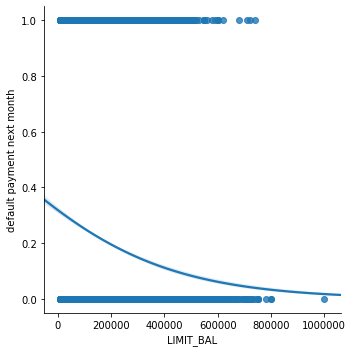

In [319]:
sns.lmplot(x='LIMIT_BAL',y='default payment next month', 
           data=df,logistic=True)
np.corrcoef(df['LIMIT_BAL'],df['default payment next month'])

## 4. Feature Selection

## Baseline model for comparisons

In [325]:
#baseline logistic regression
test_df = pd.read_csv('classification_lab_data.csv')
y = test_df['default payment next month']
test_df.drop(['default payment next month'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(test_df, y, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train =pd.DataFrame(data=scaler.transform(X_train), columns=test_df.columns)
X_test =pd.DataFrame(data=scaler.transform(X_test), columns=test_df.columns)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy: ',metrics.accuracy_score(y_pred, y_test))
print('F1: ',metrics.f1_score(y_pred, y_test))

Accuracy:  0.8154166666666667
F1:  0.35610465116279066


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [367]:
#Same, but with upsampling to deal with class imbalance
from sklearn.utils import resample
upsampling = pd.read_csv('classification_lab_data.csv')
default = upsampling[upsampling['default payment next month']==1]
no_default = upsampling[upsampling['default payment next month']==0]
default_upsampled = resample(default,
                          replace=True, # sample with replacement
                          n_samples=len(no_default)) # match number in majority class)
upsampled = pd.concat([no_default,default_upsampled])
y_upsampled = upsampled['default payment next month']
upsampled.drop(['default payment next month'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(upsampled, y_upsampled, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train =pd.DataFrame(data=scaler.transform(X_train), columns=test_df.columns)
X_test =pd.DataFrame(data=scaler.transform(X_test), columns=test_df.columns)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy: ',metrics.accuracy_score(y_pred, y_test))
print('F1: ',metrics.f1_score(y_pred, y_test))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy:  0.674200882706968
F1:  0.6653846153846154


In [368]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
print('Accuracy: ',metrics.accuracy_score(y_knn_pred, y_test))
print('F1: ',metrics.f1_score(y_knn_pred, y_test))

Accuracy:  0.8058044670322322
F1:  0.8214900417998525


In [342]:
df.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,edu_0,edu_1,edu_2,edu_3,edu_4,edu_5,edu_6,strict_dec,strict_inc,debt_ratio,had_spike,bal_growth,final_growth,pay_cat_sum,good_payment_standing,bad_payment history,past_pay_cat_sum,good_standing_bad_history,under_25,25_to_35,35_to_54,55_and_up,retired_women,single_50s
0,50000,0,0,49,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1,0,0,1,0,0,0,0,1,0,1.804620,0,-11161,-416,0.0,1,0,0.0,0,0,0,1,0,0,0
1,30000,0,1,39,0,0,0,0,0,0,20893,22206,19273,16469,14670,11214,2007,2000,2000,417,1500,1500,0,0,0,1,0,0,0,0,0,0,0.696433,0,9679,-1313,0.0,1,0,0.0,0,0,0,1,0,0,0
2,260000,0,0,27,0,0,0,0,0,0,158711,129796,101721,76699,56738,39134,30000,4132,3410,2600,1800,1200,0,0,1,0,0,0,0,0,0,1,0.610427,0,119577,28915,0.0,1,0,0.0,0,0,1,0,0,0,0
3,200000,1,1,33,0,0,0,0,0,0,23762,25944,26988,25237,22131,13774,4000,2000,600,3000,4000,100,0,0,0,1,0,0,0,0,0,0,0.118810,0,9988,-2182,0.0,1,0,0.0,0,0,1,0,0,0,0
4,50000,0,0,27,0,0,0,0,0,0,14614,15622,16342,17653,17697,18068,1558,1278,1589,633,656,783,0,0,1,0,0,0,0,0,1,0,0.292280,0,-3454,-1008,0.0,1,0,0.0,0,0,1,0,0,0,0


## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [369]:
df.head()
feature_list= ['LIMIT_BAL','SEX','MARRIAGE','edu_0','edu_1','edu_2','edu_3','edu_4','edu_5','edu_6',
               'strict_inc','pay_cat_sum','good_payment_standing','bad_payment history','past_pay_cat_sum',
              'good_standing_bad_history','under_25','35_to_54','55_and_up','retired_women','single_50s','debt_ratio']

logistic1 = df[['default payment next month'] + feature_list]
log_default = logistic1[logistic1['default payment next month']==1]
log_no_default = logistic1[logistic1['default payment next month']==0]
log_default_upsampled = resample(log_default,
                          replace=True, # sample with replacement
                          n_samples=len(log_no_default)) # match number in majority class)
log_upsampled = pd.concat([log_no_default,log_default_upsampled])

log_y = log_upsampled['default payment next month']
log_features = log_upsampled.drop(['default payment next month'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(log_features, log_y, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train =pd.DataFrame(data=scaler.transform(X_train), columns=log_features.columns)
X_test =pd.DataFrame(data=scaler.transform(X_test), columns=log_features.columns)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy: ',metrics.accuracy_score(y_pred, y_test))
print('F1: ',metrics.f1_score(y_pred, y_test))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy:  0.7071017787882841
F1:  0.6776567559611422


In [372]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
print('Accuracy: ',metrics.accuracy_score(y_knn_pred, y_test))
print('F1: ',metrics.f1_score(y_knn_pred, y_test))

Accuracy:  0.8721412331148857
F1:  0.8802005012531329


In [362]:
F1_list = []
k_range = list(range(1,17,2))
for k in range(1,17,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_knn_pred = knn.predict(X_test)
    F1_list.append(metrics.f1_score(y_knn_pred, y_test))

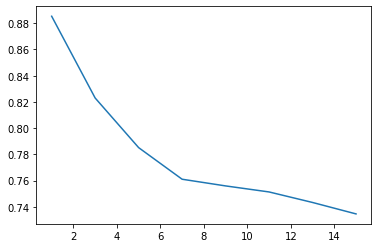

In [363]:
plt.plot(k_range,F1_list)

In [364]:
max(F1_list)

0.8853188334157193

In [352]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=4,criterion='entropy')
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('Accuracy: ',metrics.accuracy_score(y_pred_tree, y_test))
print('F1: ',metrics.f1_score(y_pred_tree, y_test))

Accuracy:  0.7026882439481076
F1:  0.7028472129394465


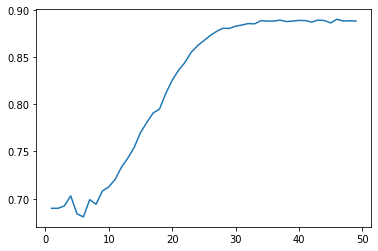

In [366]:
depths = list(range(1,50))
F1_list = []
for depth in depths:
    tree_clf = DecisionTreeClassifier(max_depth=depth,criterion='entropy')
    tree_clf.fit(X_train, y_train)
    y_pred_tree = tree_clf.predict(X_test)
    F1_list.append(metrics.f1_score(y_pred_tree, y_test))
plt.plot(depths,F1_list)

In [361]:
max(F1_list)

0.8900976634936333

In [377]:
poly_df

array([[1.00000000e+00, 5.00000000e+04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.25665334e+00],
       [1.00000000e+00, 3.00000000e+04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.85019388e-01],
       [1.00000000e+00, 2.60000000e+05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.72621028e-01],
       ...,
       [1.00000000e+00, 5.00000000e+04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.67603794e+00],
       [1.00000000e+00, 3.00000000e+05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.00267111e-05],
       [1.00000000e+00, 6.00000000e+04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.07738447e-01]])

In [378]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly_df = pd.DataFrame(poly.fit_transform(df[feature_list]))

poly_df['default payment next month'] = df['default payment next month']
poly_default = poly_df[poly_df['default payment next month']==1]
poly_no_default = poly_df[poly_df['default payment next month']==0]

poly_default_upsampled = resample(poly_default,
                          replace=True, # sample with replacement
                          n_samples=len(poly_no_default)) # match number in majority class)


poly_upsampled = pd.concat([poly_no_default,poly_default_upsampled])
ys = poly_upsampled['default payment next month']
poly_features = poly_upsampled.drop(['default payment next month'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(poly_features, ys, test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train)
X_train =pd.DataFrame(data=scaler.transform(X_train), columns=poly_features.columns)
X_test =pd.DataFrame(data=scaler.transform(X_test), columns=poly_features.columns)

In [379]:
from sklearn.feature_selection import RFECV
knn = KNeighborsClassifier(n_neighbors=3)
selector = RFECV(estimator=knn, step=2, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)
selected_columns = X_train.columns[selector.support_]
removed_columns = X_train.columns[~selector.support_]
len(removed_columns)

RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

## 6. Model Evaluation

## 7. Final Model